In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle

In [273]:
df=pd.read_csv('Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [274]:
df.shape

(545, 13)

In [275]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [276]:
df.nunique()

price               219
area                284
bedrooms              6
bathrooms             4
stories               4
mainroad              2
guestroom             2
basement              2
hotwaterheating       2
airconditioning       2
parking               4
prefarea              2
furnishingstatus      3
dtype: int64

In [277]:
numeric_cols=df.select_dtypes(include=np.number).columns.tolist()
categorical_cols=df.select_dtypes(include='object').columns.tolist()
print("numeric_cols=",numeric_cols)
print("categorical_cols=",categorical_cols)


numeric_cols= ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
categorical_cols= ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


In [278]:
binary_map = {'yes': 1, 'no': 0}
for col in ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']:
    df[col] = df[col].map(binary_map)
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)

bool_cols = ['furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']
df[bool_cols] = df[bool_cols].astype(int)
df

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,0,1
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1,0
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,0,1
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,0,0


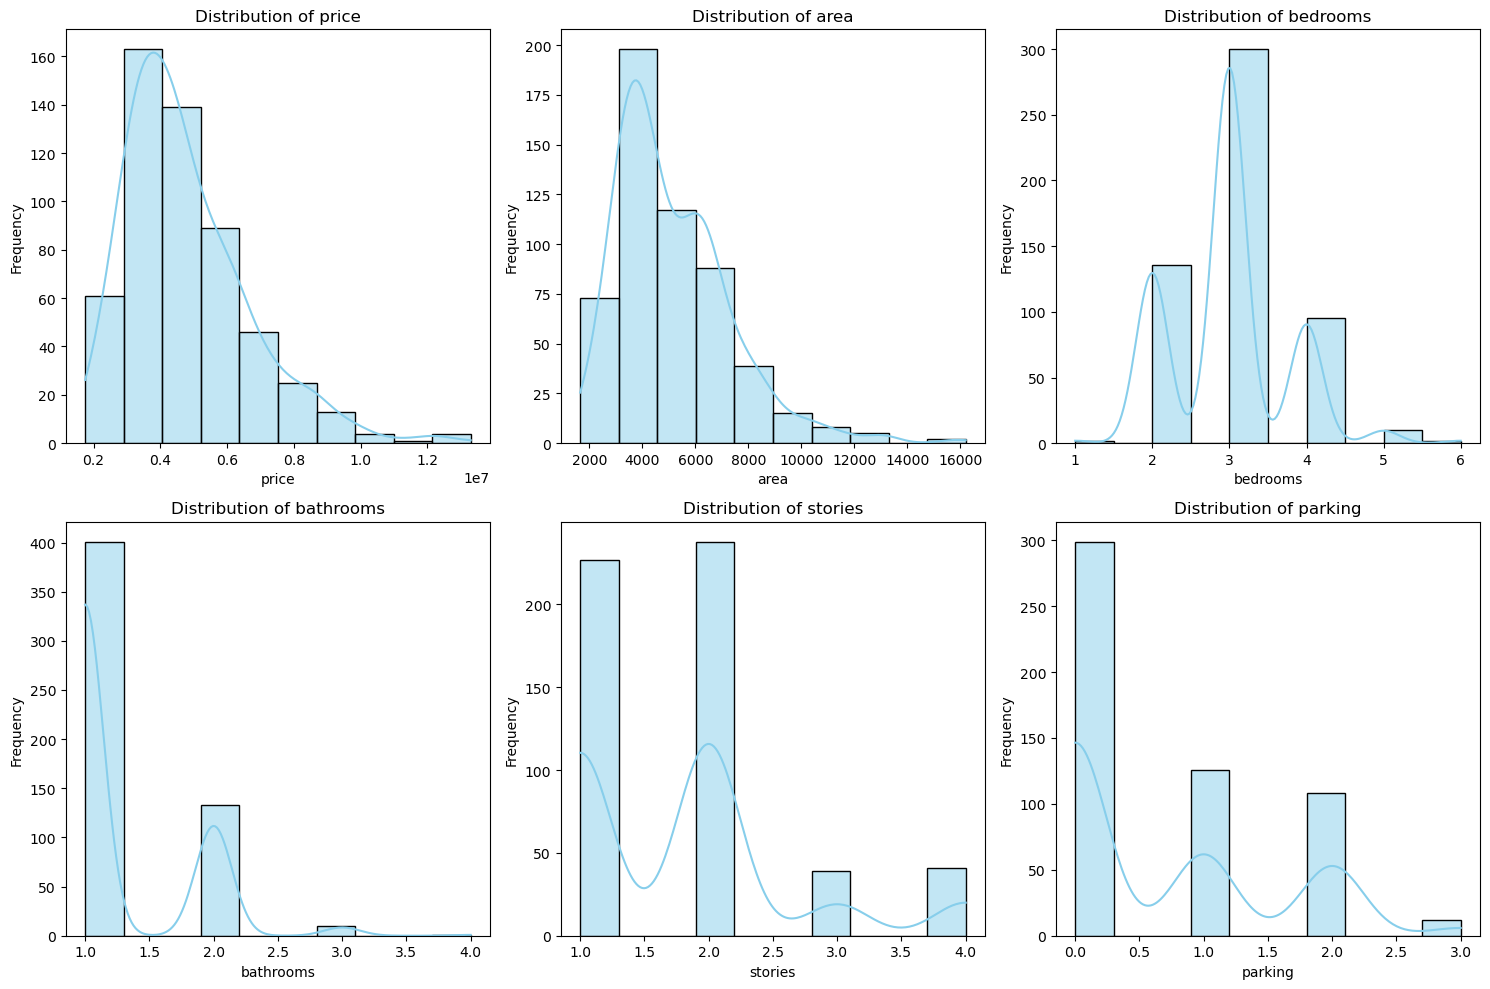

In [279]:
n_cols = 3
n_rows = -(-len(numeric_cols) // n_cols)  # Ceiling division

plt.figure(figsize=(15, 5 * n_rows))

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df[col], bins=10, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [280]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


In [281]:
df[numeric_cols].skew()


price        1.212239
area         1.321188
bedrooms     0.495684
bathrooms    1.589264
stories      1.082088
parking      0.842062
dtype: float64

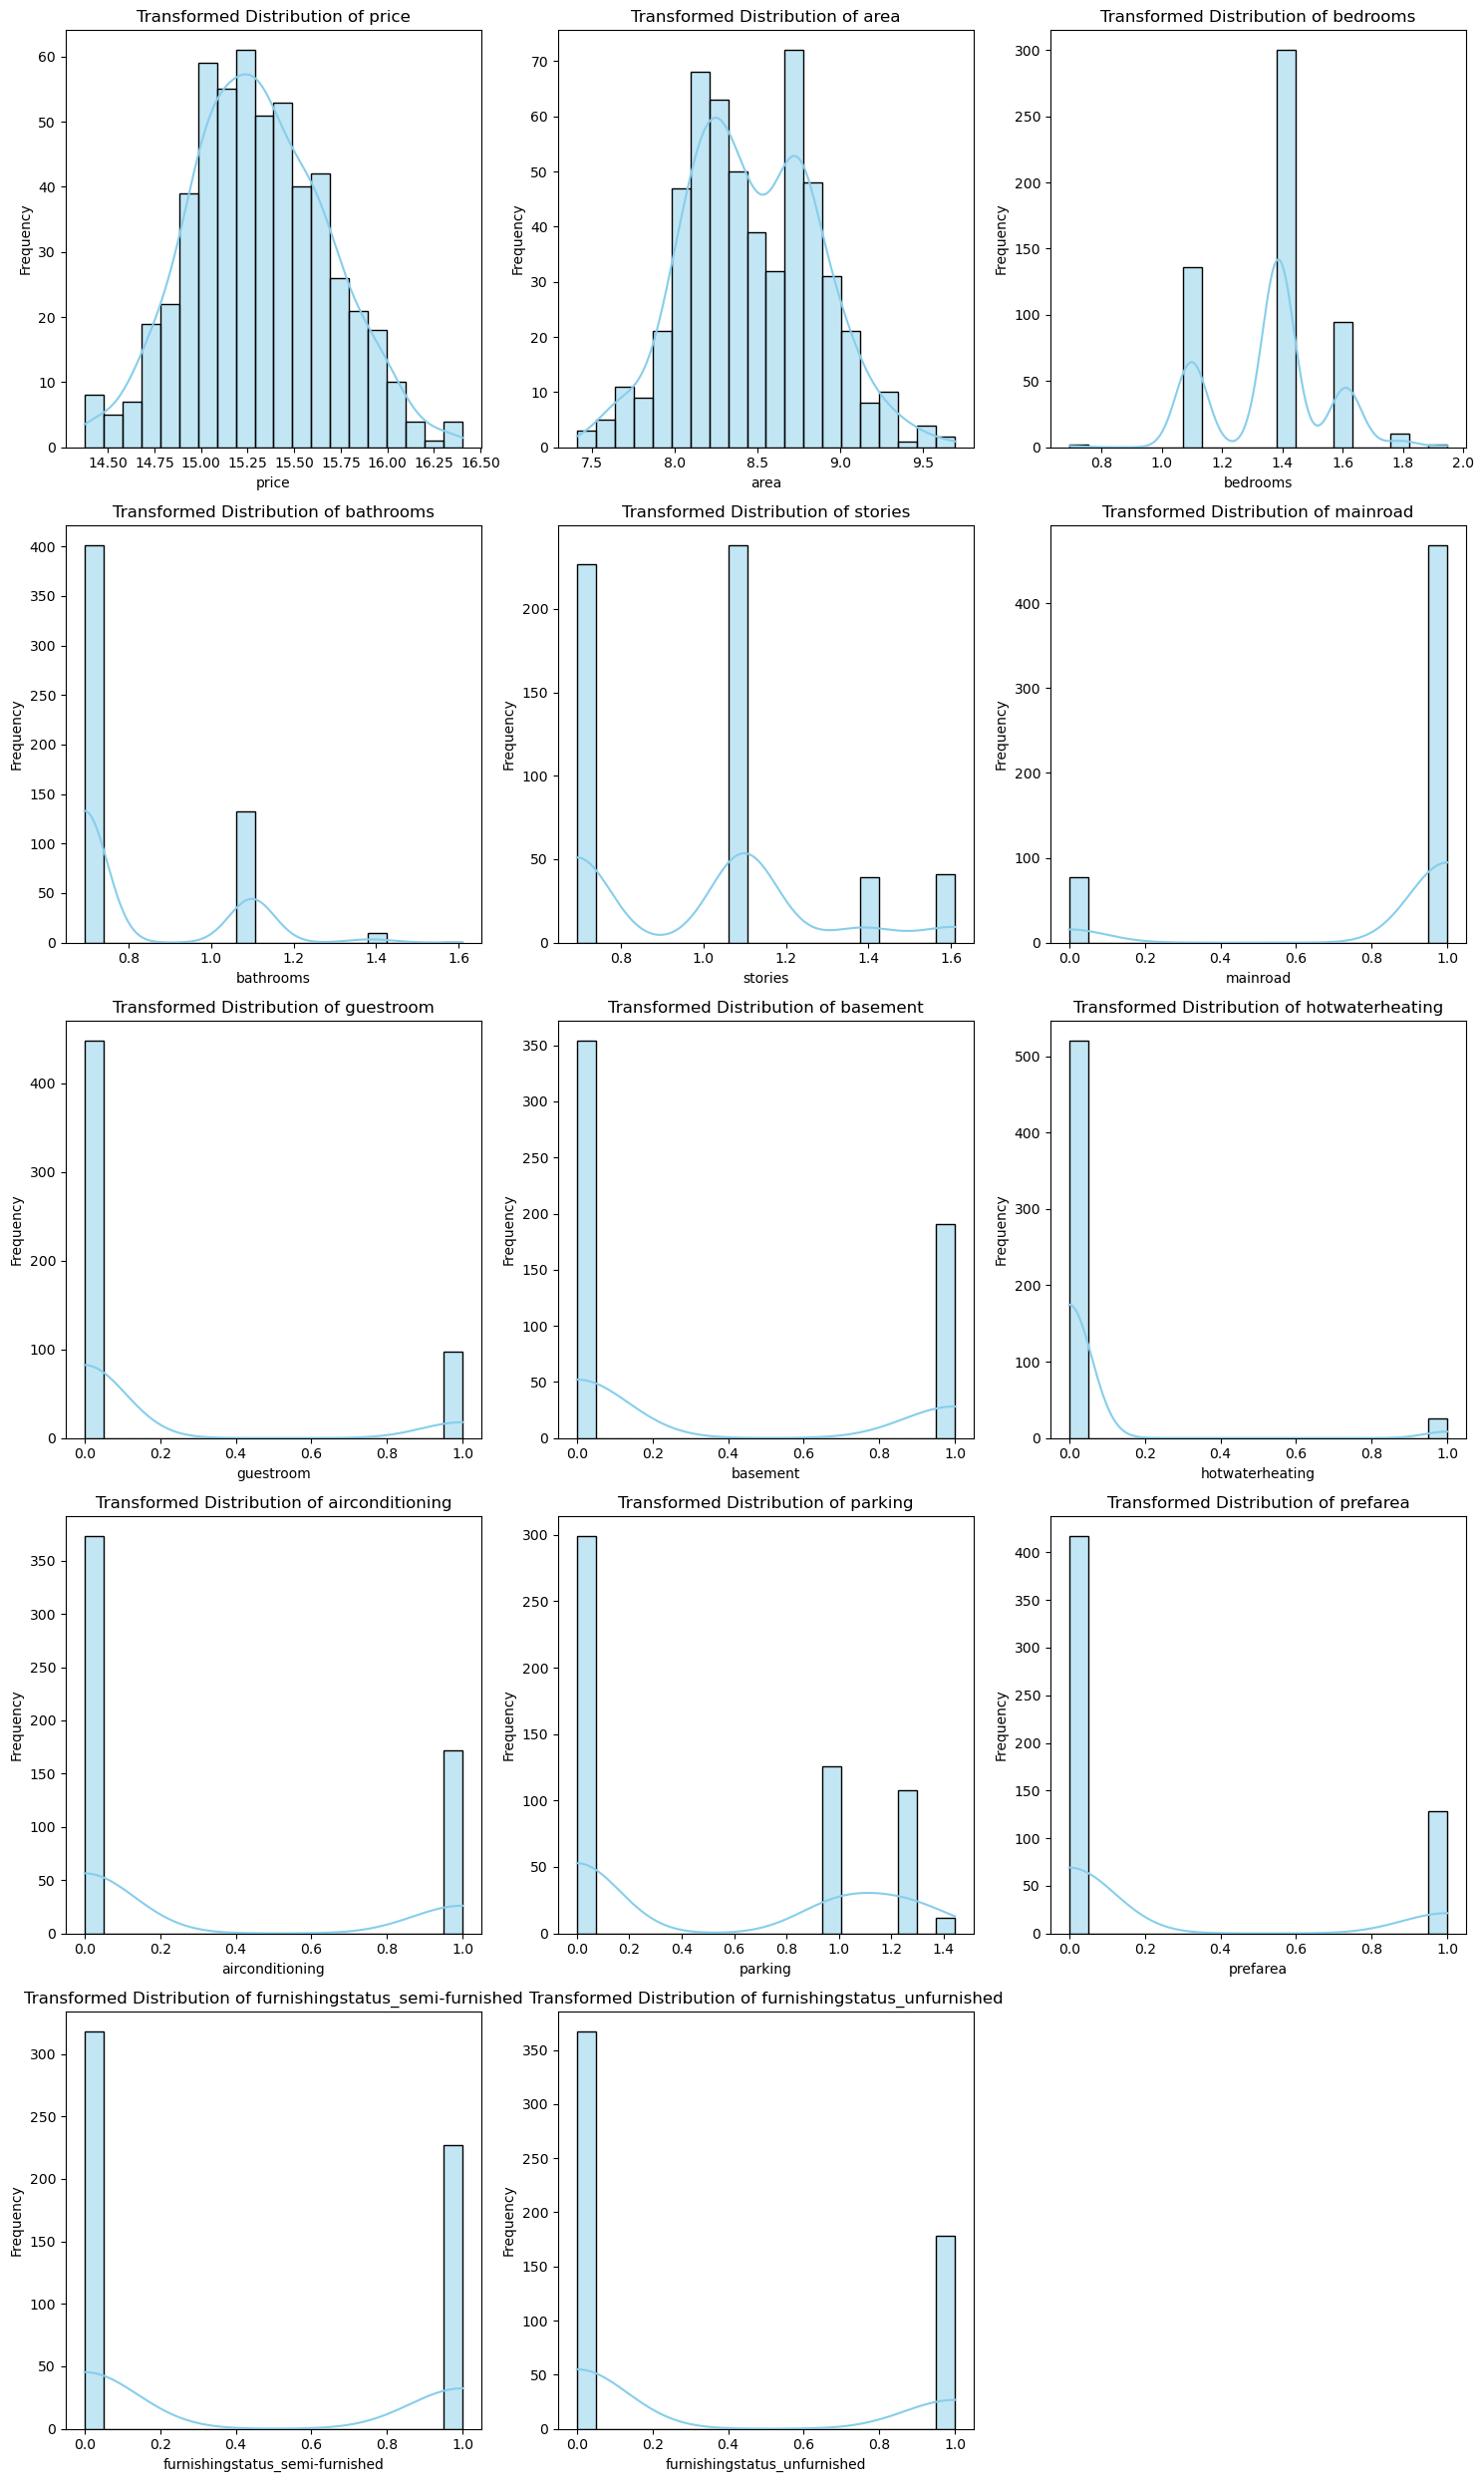

In [282]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

num_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in num_cols:
    if (df[col] <= 0).any():
        df[col] = np.cbrt(df[col])
    else:
        df[col] = np.log1p(df[col])

n_cols = 3
n_rows = -(-len(num_cols) // n_cols)

plt.figure(figsize=(15, 5 * n_rows))

for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df[col], bins=20, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Transformed Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [283]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,16.403275,8.912069,1.609438,1.098612,1.386294,1.0,0.0,0.0,0.0,1.0,1.259921,1.0,0.0,0.0
1,16.321037,9.100637,1.609438,1.609438,1.609438,1.0,0.0,0.0,0.0,1.0,1.442250,0.0,0.0,0.0
2,16.321037,9.206433,1.386294,1.098612,1.098612,1.0,0.0,1.0,0.0,0.0,1.259921,1.0,1.0,0.0
3,16.318175,8.922792,1.609438,1.098612,1.098612,1.0,0.0,1.0,0.0,1.0,1.442250,1.0,0.0,0.0
4,16.250001,8.912069,1.609438,0.693147,1.098612,1.0,1.0,1.0,0.0,1.0,1.259921,0.0,0.0,0.0


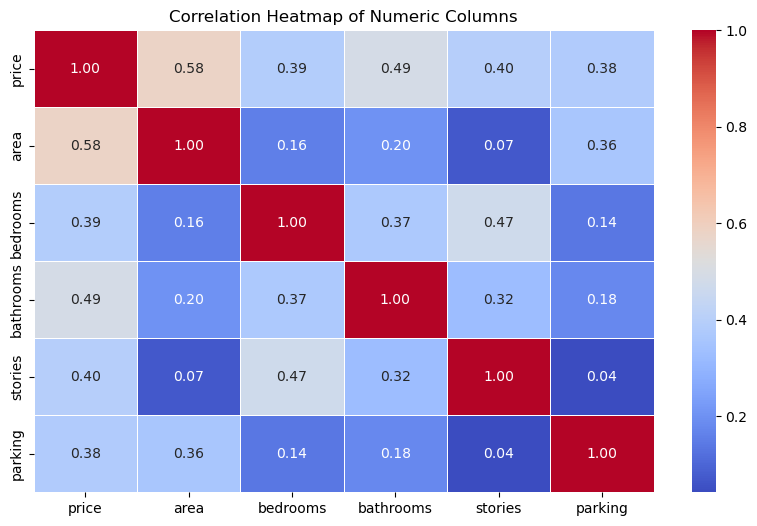

In [284]:
corr = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Columns")
plt.show()

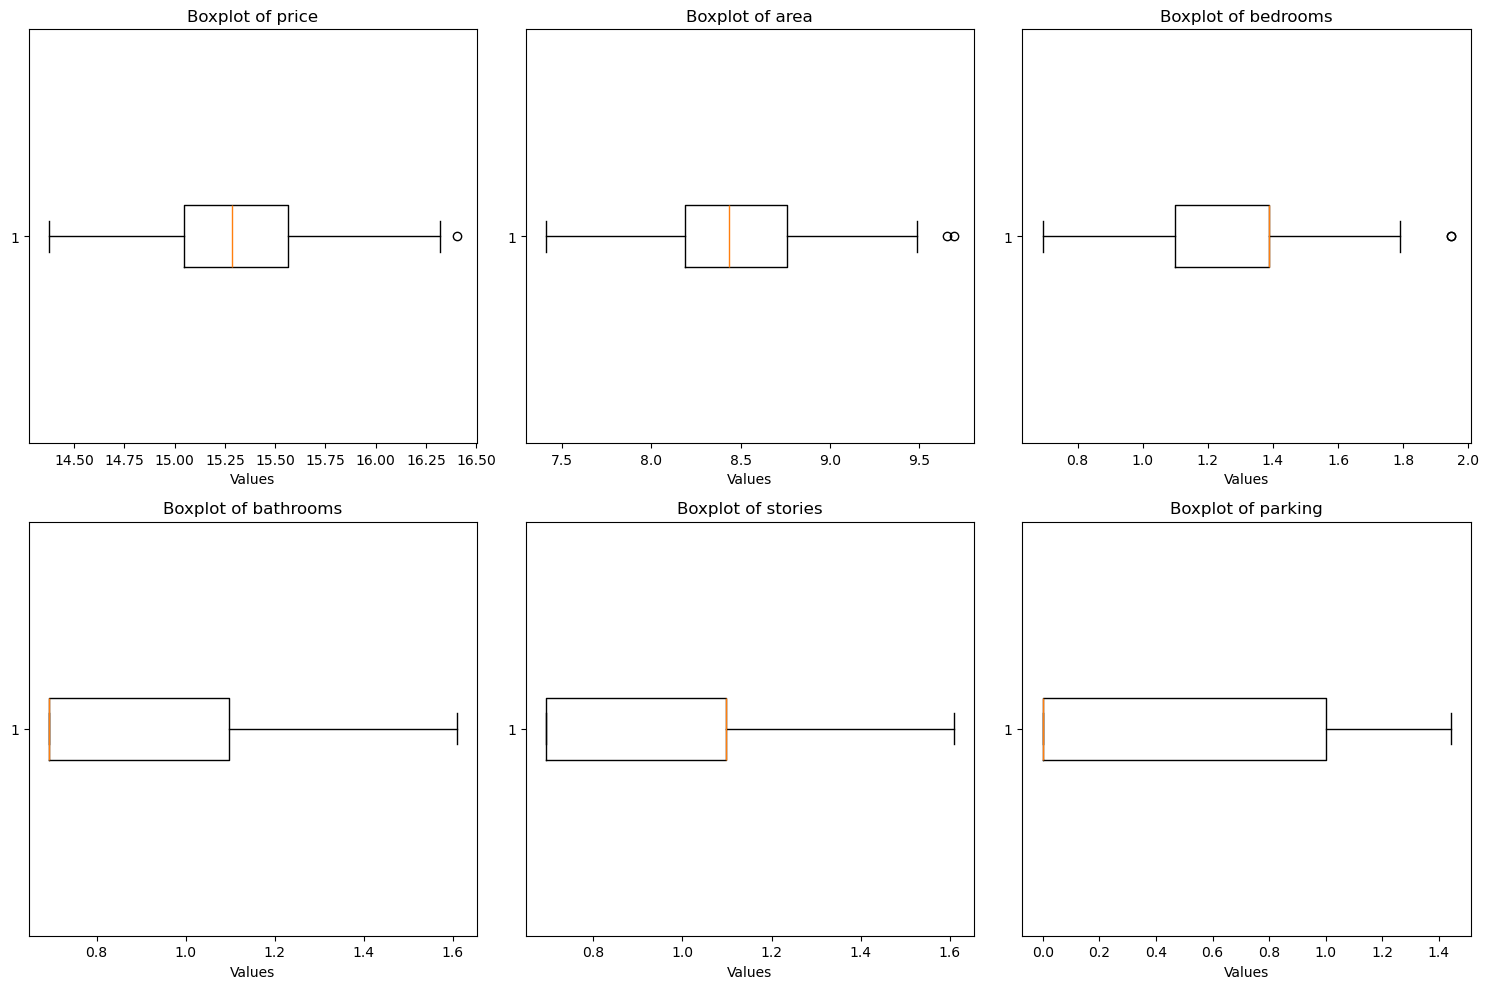

In [285]:
import matplotlib.pyplot as plt

numeric_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

# Create subplots automatically
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows x 3 columns
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    ax.boxplot(df[col], vert=False)
    ax.set_title(f'Boxplot of {col}')
    ax.set_xlabel('Values')

# Hide unused axes (if any)
for ax in axes[len(numeric_cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()



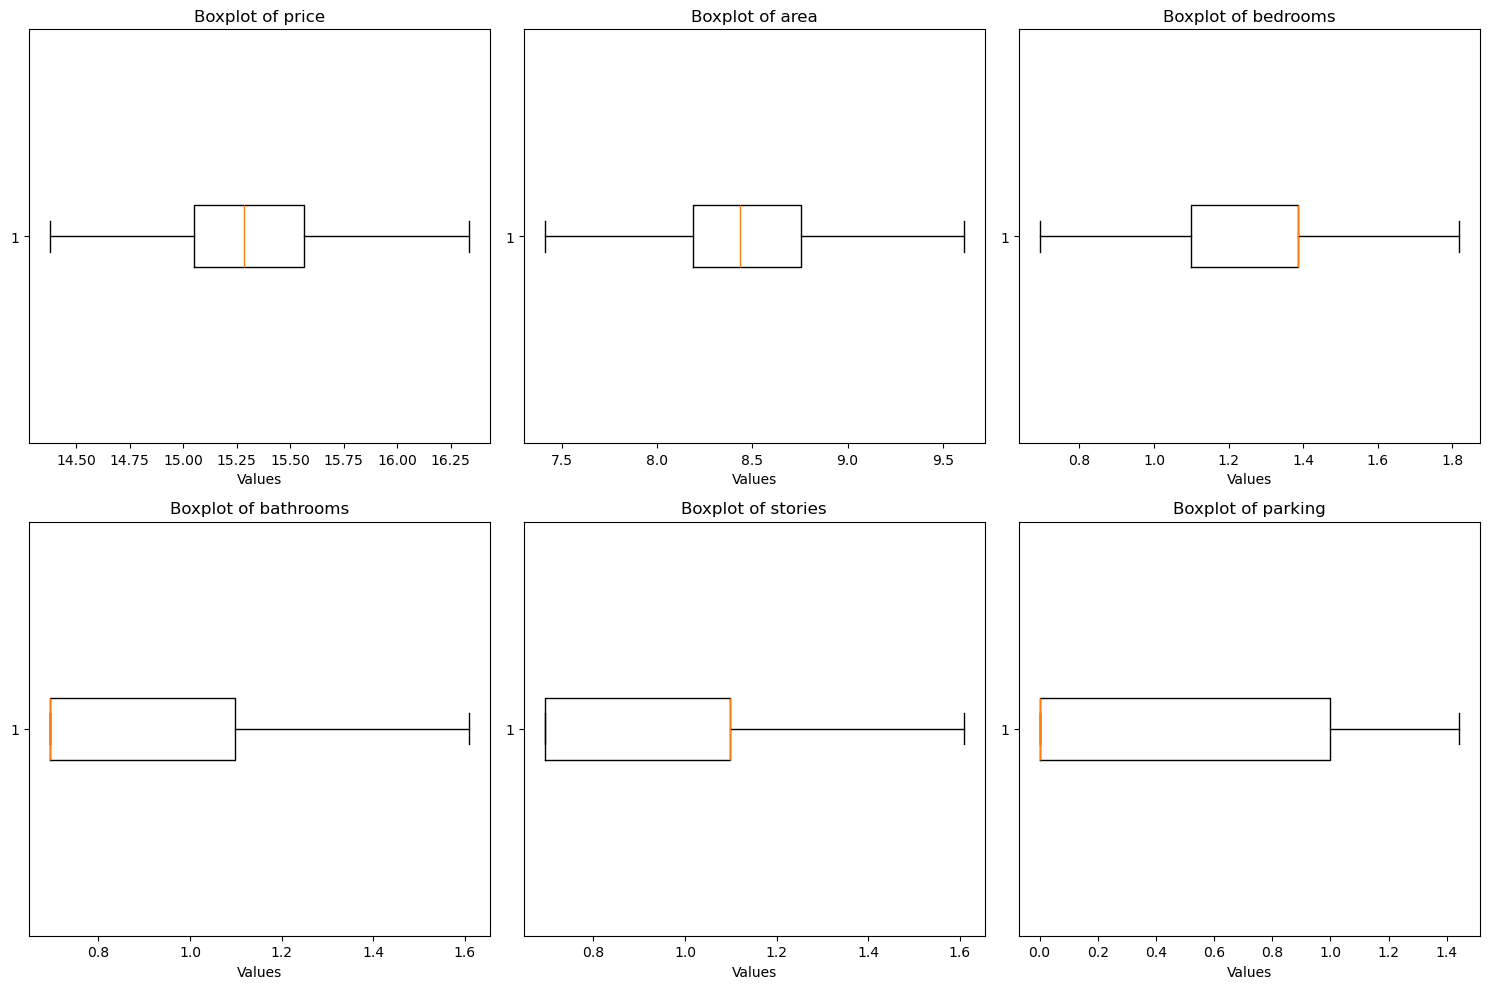

In [286]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
import matplotlib.pyplot as plt
numeric_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
fig, axes = plt.subplots(2, 3, figsize=(15, 10)) 
axes = axes.flatten()
for ax, col in zip(axes, numeric_cols):
    ax.boxplot(df[col], vert=False)
    ax.set_title(f'Boxplot of {col}')
    ax.set_xlabel('Values')
for ax in axes[len(numeric_cols):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [291]:

X = df[num_cols]
y = df['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# k-NN Regressor with 5-fold CV
k = 5
knn = KNeighborsRegressor(n_neighbors=k)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse = np.sqrt(-cross_val_score(knn, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error'))
mean_cv_rmse = cv_rmse.mean()
print(f"CV RMSE (5-fold): {mean_cv_rmse:.2f}")

# Fit on train, predict on test
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# Test RMSE and R²
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test R²: {test_r2:.3f}")

CV RMSE (5-fold): 0.16
Test RMSE: 0.20
Test R²: 0.786


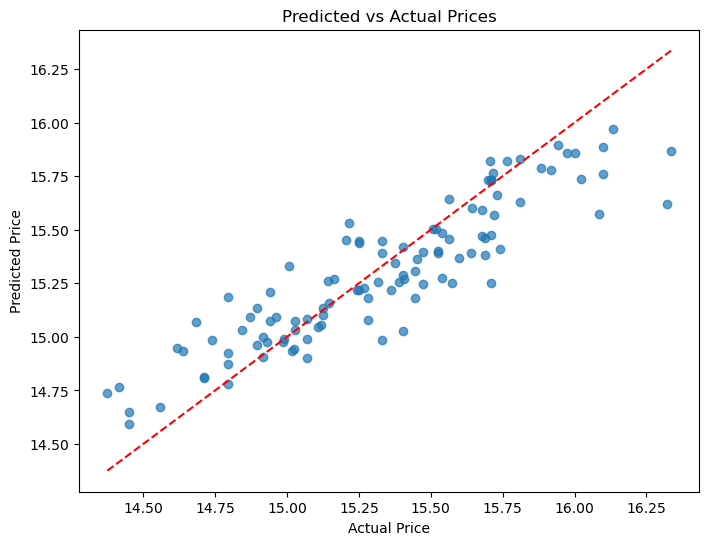

In [288]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.show()

In [289]:
import pickle

with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn, f)

with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("KNN model and scaler saved successfully!")


KNN model and scaler saved successfully!
